In [29]:
%pip install icecream

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
print=ic

In [199]:
class BeamElement2D:
    def  __init__(self, node_indeces, node_coordinates,E,A,L,I, theta = 0):
        self.node_indeces = node_indeces
        self.node_coordinates = node_coordinates
        self.E = E
        self.A = A
        self.L = L
        self.I = I
        self.theta = theta
        self.k_elem_local = None

    def get_local_stiffness_matrix(self):
        # returns the stiffness matrix for the element in local coordinates
        E = self.E; I = self.I; L = self.L
        self.k_elem_local = np.array(
            [[12*E*I/L**3, 6*E*I/L**2, -12*E*I/L**3, 6*E*I/L**2],
             [6*E*I/L**2, 4*E*I/L, -6*E*I/L**2, 2*E*I/L],
             [-12*E*I/L**3, -6*E*I/L**2, 12*E*I/L**3, -6*E*I/L**2],
             [6*E*I/L**2, 2*E*I/L, -6*E*I/L**2, 4*E*I/L]])
        return self.k_elem_local

    def get_global_stiffness_matrix(self):
        self.get_local_stiffness_matrix()
        # returns the global stiffness matrix for the element in global coordinates
        S = np.sin(np.deg2rad(self.theta))
        C = np.cos(np.deg2rad(self.theta))
        # self.R = np.array([[C, S],
        #               [-S, C]])
        self.T = np.array([
            [C,0,0,0],
            [0,1,0,0],
            [0,0,C,0],
            [0,0,0,C]])
        self.K_elem_global = self.T.T @ self.k_elem_local @ self.T
        return self.K_elem_global

In [200]:
class BeamSystem2D:
    def __init__(self, elements, num_nodes, forces, boundary_conditions):
        self.elements = elements
        self.num_nodes = num_nodes
        self.forces = forces
        self.boundary_conditions = boundary_conditions


In [240]:
class Solver:
    def __init__(self, system):
        self.system = system

    def solve(self):
        K_global, F_global = self.assemble_global_matrices()

        self.K_global = np.array([
            [3e3, 3e6, -3e3, 3e6, 0, 0],
            [3e6, 4e9, -3e6, 2e9, 0,0],
            [-3e3, -3e6, 6e3, 0, -3e3, 3e6],
            [3e6, 2e9, 0, 8e9, -3e6, 2e9],
            [0,0, -3e3, -3e6, 3e3, -3e6],
            [0,0, 3e6, 2e9, -3e6, 4e9]
        ])

        Kuu, Fu = self.apply_boundary_conditions()
        displacements = self.solve_displacements()
        # stresses = self.calculate_stresses()

        # return self.displacements, self.stresses

    def assemble_global_matrices(self):
        # Assemble global stiffness
        self.K_global = np.zeros((self.system.num_nodes*2, self.system.num_nodes*2)) # multiply by 2 cause for a node 2 is the DoF hence it's 2D

        for element in self.system.elements:
            K_elem = element.get_global_stiffness_matrix()
            node_per_element = len(self.system.elements[0].node_indeces) # 2 for linear

            # Get the global DOF indices for the element's nodes
            global_dof_indices = []
            for node_index in element.node_indeces:
                global_dof_indices.extend([2 * node_index, 2 * node_index + 1])  # DOFs: x, y

            for i in range(len(global_dof_indices)):
                for j in range(len(global_dof_indices)):
                    self.K_global[global_dof_indices[i], global_dof_indices[j]] += K_elem[i, j]

                    # Assemble load vector
        self.F_global = np.zeros((self.system.num_nodes*2))
        for node_index, f_x, f_y in self.system.forces:
            global_dof_index = int(2 * node_index)
            self.F_global[global_dof_index] += f_x
            self.F_global[global_dof_index + 1] += f_y

        return self.K_global, self.F_global

    def apply_boundary_conditions(self):
        known_global_indeces_y = []
        known_global_indeces_theta = []
        for node_index, constraint_y, constraint_theta in self.system.boundary_conditions:
            global_dof_index_y = int(2 * node_index)      # Vertical displacement index
            global_dof_index_theta = int(2 * node_index + 1)  # Angular displacement index
            if constraint_y == 1:
                known_global_indeces_y.append(global_dof_index_y)
            if constraint_theta == 1:
                known_global_indeces_theta.append(global_dof_index_theta)

        # Separate K and F for vertical and angular displacements
        self.Kuu_y = np.delete(np.delete(self.K_global, known_global_indeces_y, axis=0), known_global_indeces_y, axis=1)
        self.Fu_y = np.delete(self.F_global, known_global_indeces_y, axis=0)

        self.Kuu_theta = np.delete(np.delete(self.K_global, known_global_indeces_theta, axis=0), known_global_indeces_theta, axis=1)
        self.Fu_theta = np.delete(self.F_global, known_global_indeces_theta, axis=0)

        self.known_global_indeces_y = known_global_indeces_y
        self.known_global_indeces_theta = known_global_indeces_theta

        return (self.Kuu_y, self.Fu_y), (self.Kuu_theta, self.Fu_theta)

    def solve_displacements(self):
        # Solve for vertical displacements
        Du_y = np.linalg.solve(self.Kuu_y, self.Fu_y)  # unknown vertical displacements
        unknown_global_indeces_y = [i for i in range(self.system.num_nodes * 2) if i not in self.known_global_indeces_y]

        displacements_y = np.zeros((self.system.num_nodes * 2))
        displacements_y[unknown_global_indeces_y] = Du_y

        # Solve for angular displacements
        # Du_theta = np.linalg.solve(self.Kuu_theta, self.Fu_theta)  # unknown angular displacements
        # unknown_global_indeces_theta = [i for i in range(self.system.num_nodes * 2) if i not in self.known_global_indeces_theta]

        # displacements_theta = np.zeros((self.system.num_nodes * 2))
        # displacements_theta[unknown_global_indeces_theta] = Du_theta

        # # Combine displacements for reporting
        # self.displacements = displacements_y + displacements_theta

        self.Du_y = Du_y
        self.displacements = displacements_y
        return displacements_y, #displacements_theta

In [241]:
class Plotter:
    def __init__(self, solver):
        self.system = solver.system
        self.displacements = solver.displacements
        # self.stresses = solver.stresses

    def plot_system(self):
        """
        plots the truss system
        """
        for i, element in enumerate(self.system.elements):
            pos1, pos2 = element.node_coordinates
            node_index1, node_index2 = element.node_indeces
            offset = +0 # for text

            # PLOT INITIAL SYSTEM
            x1, y1 = pos1
            x2, y2 = pos2
            plt.scatter([x1,x2], [y1,y2],c="r")
            plt.plot([x1,x2], [y1,y2],c="r")
            plt.text(x1, y1+offset, node_index1, color="r", horizontalalignment='left',
        verticalalignment='top')
            plt.text(x2, y2+offset, node_index2, color="r", horizontalalignment='left',
        verticalalignment='top')


            # PLOT SYSTEM WITH DISPLACEMENTS
            x1_disp, y1_disp = pos1 + self.displacements[2*node_index1:2*node_index1+2]
            x2_disp, y2_disp = pos2 + self.displacements[2*node_index2:2*node_index2+2]

            x1_disp = x1; x2_disp = x2
            y1_disp = y1 + self.displacements[2*node_index1]; y2_disp = y2 + self.displacements[2*node_index2]

            plt.scatter([x1_disp,x2_disp], [y1_disp,y2_disp],c="b")
            plt.plot([x1_disp,x2_disp], [y1_disp,y2_disp],c="b", linestyle="--")
            plt.text(x1_disp, y1_disp+offset, node_index1, color="b", horizontalalignment='left',
        verticalalignment='top')
            plt.text(x2_disp, y2_disp+offset, node_index2, color="b", horizontalalignment='left',
        verticalalignment='top')


            # # PLOT ELEMENT INTERNAL FORCES
            # x_mid = x1_disp + (x2_disp - x1_disp) * 0.5
            # y_mid = y1_disp + (y2_disp - y1_disp) * 0.5
            # plt.text(x_mid, y_mid, f"{self.stresses[i]/1000*element.A:.2f} kN", color="black")


        plt.title("Beam Element(s)")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.show()

In [242]:
# [units: N, mm, MPa]
E = 200e3; I = 1e7; L=4e3; A = 625
P = 10e3 # applied force, f_y at the middle of the beam

connectivity = np.array([[0,1], [1,2]])
nodal_coordinates = np.array([[0,0],[L/2, 0], [L,0]])
angles_of_elements = np.array([0,0,0])

# node_index, vertical_displacement, angular_displacement
boundary_conditions = np.array([
                            [0,1,0],
                            [2,1,0]])

 # node_index, f_y, moment_z
forces = np.array([
                [0, P/2, 0],  # reaction 1
                [1, -P, 0],   # applied force
                [2, P/2, 0]]) # reaction 2

num_nodes = (np.max(connectivity) + 1)

elements = []
for i, node_indeces in enumerate(connectivity):
    node_coordinates = nodal_coordinates[node_indeces]
    element = BeamElement2D(node_indeces, node_coordinates, E,A,L,I, theta = angles_of_elements[i])
    elements.append(element)

system = BeamSystem2D(elements, num_nodes, forces, boundary_conditions)


In [243]:
solver = Solver(system)
solver.solve()
_ = print(solver.K_global, solver.F_global, solver.Kuu_y, solver.Fu_y, solver.Du_y, solver.displacements)

for i in range(0, len(solver.displacements), 2):
    nodal_disp = f"Node {i//2+1}: del_y = {solver.displacements[i]:.4f} mm, del_theta = {solver.displacements[i+1]:.4f} rad"
    print(nodal_disp)

ic| solver.K_global: array([[ 3.e+03,  3.e+06, -3.e+03,  3.e+06,  0.e+00,  0.e+00],
                            [ 3.e+06,  4.e+09, -3.e+06,  2.e+09,  0.e+00,  0.e+00],
                            [-3.e+03, -3.e+06,  6.e+03,  0.e+00, -3.e+03,  3.e+06],
                            [ 3.e+06,  2.e+09,  0.e+00,  8.e+09, -3.e+06,  2.e+09],
                            [ 0.e+00,  0.e+00, -3.e+03, -3.e+06,  3.e+03, -3.e+06],
                            [ 0.e+00,  0.e+00,  3.e+06,  2.e+09, -3.e+06,  4.e+09]])
    solver.F_global: array([  5000.,      0., -10000.,      0.,   5000.,      0.])
    solver.Kuu_y: array([[ 4.e+09, -3.e+06,  2.e+09,  0.e+00],
                         [-3.e+06,  6.e+03,  0.e+00,  3.e+06],
                         [ 2.e+09,  0.e+00,  8.e+09,  2.e+09],
                         [ 0.e+00,  3.e+06,  2.e+09,  4.e+09]])
    solver.Fu_y: array([     0., -10000.,      0.,      0.])
    solver.Du_y: array([-5.00000000e-03, -6.66666667e+00,  0.00000000e+00,  5.00000000e-03])
    s

In [245]:
Fu = solver.Fu_y[1:3]
Kuu = solver.K_global[2:4, 2:4]
Du = np.linalg.solve(Kuu, Fu)

print(f"Fu: {Fu}")
print(f"Kuu: {Kuu}")
print(f"Du: {Du}")

ic| f"Fu: {Fu}": 'Fu: [-10000.      0.]'
ic| f"Kuu: {Kuu}": 'Kuu: [[6.e+03 0.e+00]
                     [0.e+00 8.e+09]]'
ic| f"Du: {Du}": 'Du: [-1.66666667  0.        ]'


'Du: [-1.66666667  0.        ]'

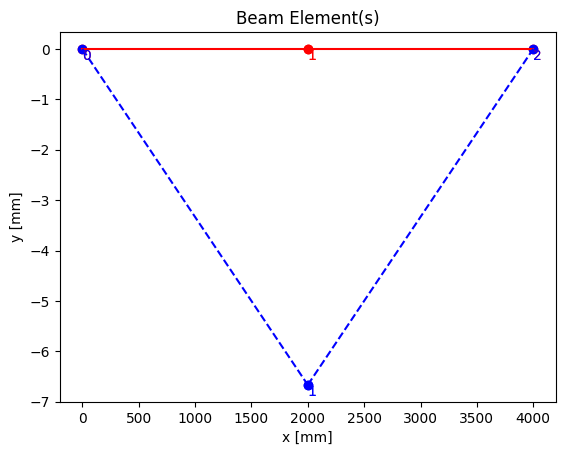

In [230]:
plotter = Plotter(solver)
plotter.plot_system()